In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="5"

In [2]:
import torch 
import numpy as np
import torch.nn as nn
import t3nsor as t3
from torchtext import data
from torchtext import datasets
import torch.optim as optim

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
TEXT = data.Field(tokenize='spacy');
LABEL = data.LabelField(dtype=torch.float);

# Corpus loader

In [5]:
import re
file = open("data/enwik8.txt", "r")
doclist = [ line for line in file ]
docstr = '' . join(doclist)
sentences = re.split(r'[.!?]', docstr)
sentences = [sentence.split() for sentence in sentences if len(sentence) > 1]

In [6]:
len(sentences)

889156

In [7]:
# Load enwik 8
data = np.loadtxt("data/enwik8.txt", dtype=str, delimiter='.')

# Create a list of sentences
sentences = [data[i].split() for i in data.nonzero()[0]]

In [8]:
def create_vocabulary(sentences, r=200):
    prevocabulary = {}
    for sentence in sentences:
        for word in sentence:
            if word in prevocabulary:
                prevocabulary[word] += 1
            else:
                prevocabulary[word] = 1

    vocabulary = {}
    idx = 0
    for word in prevocabulary:
        if (prevocabulary[word] > r):
            vocabulary[word] = idx
            idx += 1

    return vocabulary

In [9]:
vocab = create_vocabulary(sentences)
inv_vocab = {v: k for k, v in vocab.items()}

In [10]:
def create_corpus_matrix(sentences, vocabulary, window_size=5):
    """
    Create a co-occurrence matrix D from training corpus.
    """

    dim = len(vocabulary)
    D = np.zeros((dim, dim))
    s = window_size//2

    for sentence in sentences:
        l = len(sentence)
        for i in range(l):
            for j in range(max(0,i-s), min(i+s+1,l)):
                if (i != j and (sentence[i] in vocabulary) \
                    and (sentence[j] in vocabulary)):
                    c = vocabulary[sentence[j]]
                    w = vocabulary[sentence[i]]
                    D[c][w] += 1                  
    return D.T

In [11]:
D = create_corpus_matrix(sentences, vocab)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, Sampler, DataLoader

class CorpusDataset(Dataset):
    def __init__(self, corpus_matrix):
        self.D = corpus_matrix
        self.B = self.D.sum(axis=0, keepdims=True) * \
            self.D.sum(axis=1, keepdims=True) / self.D.sum()
        self.vocab_size = self.D.shape[0]
        self.w, self.c = corpus_matrix.nonzero()
        self.len = len(self.w)
        self.data = {
            (self.w[i], self.c[i]): self.D[self.w[i], self.c[i]]
            for i in range(self.len)}
        self.negative = {
            (self.w[i], self.c[i]): self.B[self.w[i], self.c[i]]
            for i in range(self.len)}
        
    def __getitem__(self, index):
        i, j = self.w[index], self.c[index]
        dct = {
            "word": i,
            "context": j,
            "count": self.data[(i, j)].astype(np.float32),
            "negative": self.negative[(i, j)].astype(np.float32)}
        return dct
    
    def __len__(self):
        return self.len
    

class CorpusSampler(Sampler):
    def __init__(self, dataset):
        self.dataset = dataset
        self.len = len(self.dataset)
        self.indices = np.arange(self.len)
        np.random.shuffle(self.indices)
    
    def __iter__(self):
        return iter(self.indices)
    
    def __len__(self):
        return self.len

In [13]:
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.w_emb = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim)
        self.c_emb = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim)
        self.init_emb()

    def init_emb(self):
        """Initialize embedding weight like word2vec.
        The w_emb is a uniform distribution in
        [-0.5/em_size, 0.5/emb_size], and the elements
        of c_embedding are zeroes.
        """
        initrange = 0.5 / self.embedding_dim
        self.w_emb.weight.data.uniform_(-initrange, initrange)
        self.c_emb.weight.data.uniform_(-0, 0)

    def forward(self, word_indices, context_indices):
        w = self.w_emb.forward(word_indices)
        c = self.c_emb.forward(context_indices)
        return w, c

In [14]:
class WordEmbeeddings(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.emb = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim)

In [15]:
def log1p_exp(input_tensor):
    """ Computationally stable function for computing log(1+exp(x)).
    """
    x = input_tensor * input_tensor.ge(0).to(torch.float32)
    res = x + torch.log1p(
        torch.exp(-torch.abs(input_tensor)))
    return res


class Word2Vec:
    def __init__(
            self,
            skip_gram_model,
            #context_embedding,
            neg_sampling_param=5,
            learning_rate=0.025):
        self._device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")
        #self.w_emb = word_embedding.to(self._device)
        #self.c_emb = context_embedding.to(self._device)
        self.skip_gram = skip_gram_model.to(self._device)
        self.optimizer = optim.Adam(
            self.skip_gram.parameters(), lr=learning_rate)
        #self.w_optimizer = optim.SGD(
        #    self.w_emb.parameters(), lr=learning_rate)
        #self.c_optimizer = optim.SGD(
        #    self.c_emb.parameters(), lr=learning_rate)
        self.k = neg_sampling_param
        
    def to_tensor(self, *args, **kwargs):
        return torch.Tensor(*args, **kwargs).to(self._device)
        
    def train(self, batch):
        words, contexts, counts, negatives = \
            batch["word"], batch["context"], \
            batch["count"], batch["negative"]
        words = torch.LongTensor(words).to(self._device)
        contexts = torch.LongTensor(contexts).to(self._device)
        counts = self.to_tensor(counts)
        negatives = self.to_tensor(negatives)
        
        #w_emb = self.w_emb(words)
        #c_emb = self.c_emb(contexts)
        w_emb, c_emb = self.skip_gram(words, contexts)
        wc = torch.einsum("bi,bi->b", (w_emb, c_emb))
        loss = (log1p_exp(-wc) * counts + \
            self.k * negatives * log1p_exp(wc)).mean()
        
        # update embeddings parameters
        #self.w_optimizer.zero_grad()
        #self.c_optimizer.zero_grad()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        #self.w_optimizer.step()
        #self.c_optimizer.step()
        
        metrics = {"loss": loss.item()}
        return metrics

In [16]:
dataset = CorpusDataset(D)

In [17]:
vocab_size = D.shape[0]
embedding_dim = 100
batch_size = 50

#word_emb = WordEmbedding(vocab_size, embedding_dim)
#context_emb = WordEmbedding(vocab_size, embedding_dim)
skip_gram_model = SkipGramModel(vocab_size, embedding_dim)

In [18]:
model = Word2Vec(skip_gram_model, learning_rate=1e-3)

In [19]:
import tqdm

In [20]:
epoch_losses = []
losses = []

for epoch in range(1, 10):
    sampler = CorpusSampler(dataset)
    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=1,
        pin_memory=torch.cuda.is_available(),
        sampler=sampler)

    for i, batch in tqdm.tqdm(enumerate(loader)):
        metrics = model.train(batch)
        losses.append(metrics["loss"])
        #if (i % 100 == 0):
        #    print (metrics["loss"])

    if epoch % 1 == 0:
        avg_loss = np.mean(losses) / batch_size
        epoch_losses.append(avg_loss)
        losses = []
        print ("Loss: ", avg_loss)
        print ("---------------------")

71582it [03:12, 371.53it/s]


Loss:  0.47098362212908385
---------------------


71582it [03:12, 371.06it/s]

Loss:  0.42904599728979576
---------------------



71582it [03:15, 366.69it/s]

Loss:  0.4216364210821891
---------------------



71582it [03:11, 373.54it/s]


Loss:  0.417201519145413
---------------------


71582it [03:13, 370.73it/s]


Loss:  0.41536775999711906
---------------------


71582it [03:12, 372.28it/s]


Loss:  0.41330510919017016
---------------------


71582it [03:10, 375.95it/s]


Loss:  0.4127467479686759
---------------------


71582it [03:20, 357.61it/s]


Loss:  0.41200741522530193
---------------------


71582it [03:14, 367.47it/s]

Loss:  0.4112967561578341
---------------------


In [21]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
%matplotlib inline

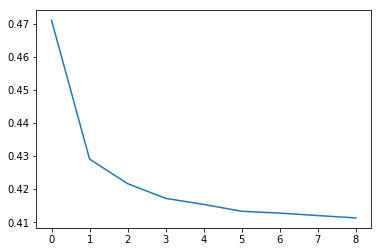

In [22]:
plt.plot(epoch_losses)

In [24]:
ws = torch.LongTensor(np.arange(vocab_size))[None, :]
emb_matrix = model.skip_gram.w_emb(ws.to(model._device))[0].detach().cpu().numpy()

In [25]:
class WordVectors:
    
    def __init__(self, vocabulary, embedding_matrix):
        self.vocab = vocabulary
        self.W = embedding_matrix
        self.inv_vocab = {v: k for k, v in self.vocab.items()}
        
    def word_vector(self, word):
        """ Takes word and returns its word vector.
        """
        if word in self.vocab:
            vec = self.W[:,int(self.vocab[word])]
            vec = vec
        else:
            print ("No such word in vocabulary.")
            vec = None
            
        return vec
    
    def nearest_words(self, word, top=10, display=False):
        """ Takes word from the vocabulary and returns its top_n
        nearest neighbors in terms of cosine similarity.
        """

        vec = self.word_vector(word)[None, :]

        cosines = cosine_similarity(self.W.T, vec)[:, 0]
        args = np.argsort(cosines)[::-1]       

        nws = []
        for i in range(1, top+1):
            nws.append((self.inv_vocab[args[i]], round(cosines[args[i]], 3)))
            if (display):
                print (self.inv_vocab[args[i]], round(cosines[args[i]], 3))
        return nws

In [26]:
word_model = WordVectors(vocab, emb_matrix.T)

In [45]:
word_model.nearest_words("bear")

[('linguistic', 0.826),
 ('via', 0.82),
 ('org', 0.816),
 ('rough', 0.814),
 ('offer', 0.813),
 ('enter', 0.812),
 ('horse', 0.811),
 ('output', 0.808),
 ('bow', 0.807),
 ('screen', 0.802)]

In [29]:
word_model.nearest_words("one")

[('nine', 0.81),
 ('two', 0.728),
 ('seven', 0.725),
 ('eight', 0.714),
 ('six', 0.71),
 ('five', 0.693),
 ('october', 0.674),
 ('four', 0.669),
 ('three', 0.667),
 ('zero', 0.65)]